# KEYS Take Away

- Structure of ARIMA
  +  Mô hình được áp dụng trên các chuỗi đặc thù có yếu tố thời gian. Một mô hình chuỗi thời gian thường dự báo dựa trên giả định rằng các qui luật trong quá khứ sẽ lặp lại ở tương lai. Chúng ta đang mô hình hóa mối quan hệ trong quá khứ giữa biến độc lập (biến đầu vào) và biến phụ thuộc (biến mục tiêu). Dựa vào mối quan hệ này để dự đoán giá trị trong tương lai của biến phụ thuộc.<br>
  <br>
  + Những qui luật đặc trưng như : yếu tố chu kỳ, mùa vụ và yếu tố xu hướng.
  <br>
  
  + Trend
  + Seasonality
  + Cyclicality(repeating pattern but no fixed period)
  + White nose(series of measurement, where each value is uncorrelated with previous value - ex:flipping coin)
  + Stationarity(distribution of data doesn't change with time). 3 criteria to fulfill:
      - zero trend, isn't growing or shrinking
      - variance is constant (the avg distance of data points from zero line isnt changing)
      - autocorrelation is constant (how each value in time series related to its neighbors stays the same)

  + Making time series stationary
      - augemented dicky_fuller test if our time series is non-stationary
      - Split dataset
  

<br> - Fit ARIMA model
<br> - Optimize model
- Make forecasts
- Calculate Uncertainty in predictions


# Libraries

In [1]:
!pip install pmdarima

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pmdarima import auto_arima #func to compute sarima model
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller

import warnings
# Ignore all warnings
warnings.filterwarnings('ignore')


# COFFEE Data

In [3]:
#Read coffee data & preprocessing data
coffee_df = pd.read_excel('coffee_data.xlsx',index_col='Ngày',
            parse_dates= True)

In [4]:
coffee_df.head()

,Giá Cà Phê
Ngày,
2021-01-01,31667.5
2021-01-04,32717.0
2021-01-05,32417.0
2021-01-06,32317.0
2021-01-07,32117.0


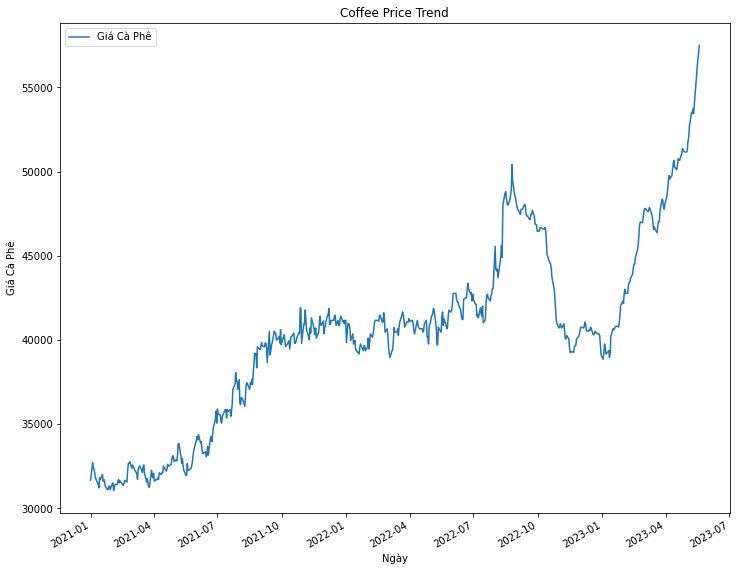

In [5]:
#Trend
fig, ax = plt.subplots(figsize=(12, 10))
coffee_df.plot(ax=ax)
plt.xlabel('Ngày')
plt.ylabel('Giá Cà Phê')
plt.title('Coffee Price Trend')
plt.show()

In [6]:
# Identify whether our time series is non-stationary / statistical tests
#The augmented Dicky-Fuller test (Test for trend non-stationarity; null hypothesis is time series is non-stationary)

In [7]:
from statsmodels.tsa.stattools import adfuller

results = adfuller(coffee_df)

In [8]:
print(results)

(0.34065079020814365, 0.9791345519947018, 9, 614, {'1%': -3.4410451945636207, '5%': -2.8662587328558566, '10%': -2.569282988466721}, 9107.833975278621)


In [9]:
#0th element test statistic: 0.341
    # more negative means more likely to be stationary
    
#1st element is test p-value: 0.98
    # if p-value is < 0.05 -> reject null hypothesis -> reject non-stationary -> must be stationary
    
#4th element is the critical test statistics (dictionary) equate to different p-values
    # if we wanted a p-value of 0.05 or below, our test statistic needed to be below -2.86

In [10]:
# Print test statistic
print('ADF Statistic:', results[0])

# Print p-value
print('p-value:', results[1])

# Print critical values
print(results[4])

ADF Statistic: 0.34065079020814365
p-value: 0.9791345519947018
{'1%': -3.4410451945636207, '5%': -2.8662587328558566, '10%': -2.569282988466721}


# Feature engineering 

In [63]:
# Taking the difference (feature engineering for non-stationary trend)
# Calculate the first difference and drop the nans
# Take first order and the seasonal difference
coffee_diff = coffee_df.diff()

In [64]:
coffee_diff

,Giá Cà Phê
Ngày,
2021-01-01,NaN
2021-01-04,1049.5
2021-01-05,-300.0
2021-01-06,-100.0
2021-01-07,-200.0
...,...
2023-05-15,1550.0
2023-05-16,500.0
2023-05-17,600.0


In [65]:
coffee_diff = coffee_diff.dropna() #add another difference diff() if needed

In [66]:
coffee_diff

,Giá Cà Phê
Ngày,
2021-01-04,1049.5
2021-01-05,-300.0
2021-01-06,-100.0
2021-01-07,-200.0
2021-01-08,-300.0
...,...
2023-05-15,1550.0
2023-05-16,500.0
2023-05-17,600.0


In [67]:
#Other tranforms
#Take the log: 
#coffee_dif= np.log(coffee_diff['Giá Cà Phê'])
#Take the square root: np.sqrt(coffee_df)
#Take the propotional change: coffee_df.shift(1)/coffee_df

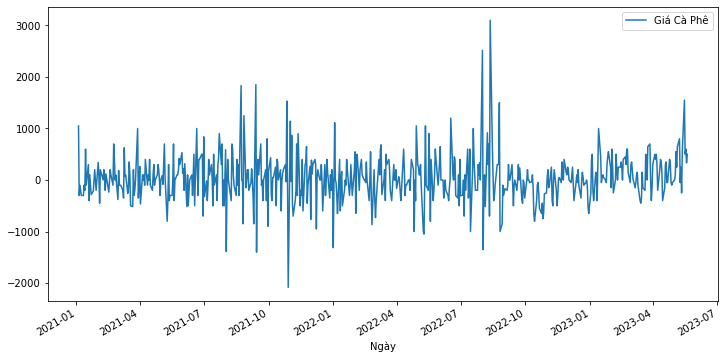

In [68]:
# Plot the time series
fig, ax = plt.subplots(figsize=(12, 6))
coffee_diff.plot(ax=ax)
plt.show()

In [17]:
results_diff = adfuller(coffee_diff)
print(results_diff)

# Calculate log-return and drop nans
coffee_log = np.log(coffee_df)
coffee_log = coffee_log.dropna()

# Run test and print
result_log = adfuller(coffee_log)
print(result_log)

(-6.118935799250959, 8.952618088234813e-08, 8, 614, {'1%': -3.4410451945636207, '5%': -2.8662587328558566, '10%': -2.569282988466721}, 9091.50223005211)
(0.391801530418125, 0.981185746322226, 1, 622, {'1%': -3.4409070618215996, '5%': -2.8661978948030686, '10%': -2.569250572471335}, -3715.9426645499607)


In [18]:
# Import
from statsmodels.tsa.seasonal import seasonal_decompose
# separate time series into three components: trend , seasonal, residual

In [39]:
# Decompose data
decomp_results = seasonal_decompose(coffee_df, period=12)

In [40]:
type(decomp_results)

statsmodels.tsa.seasonal.DecomposeResult

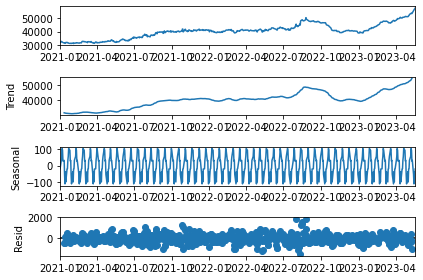

In [41]:
decomp_results.plot()
plt.show()

In [22]:
# Subtract long rolling average over N steps
coffee_df2 = coffee_diff - coffee_diff.rolling(15).mean()
coffee_df2  = coffee_df2.dropna()

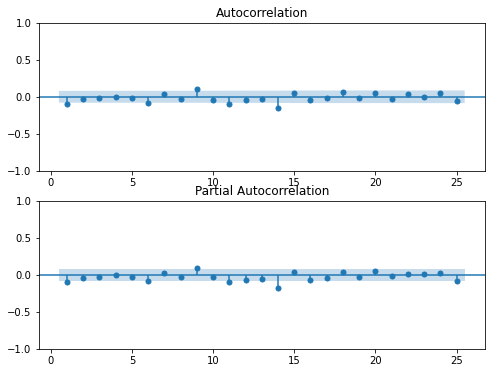

In [25]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Create the figure 
fig, (ax1, ax2) = plt.subplots(2,1,figsize=(8,6))

# Plot the ACF on ax1
plot_acf(coffee_df2, lags=25, zero=False, ax=ax1)

# Plot the PACF on ax2
plot_pacf(coffee_df2, lags=25, zero=False, ax=ax2)

plt.show()

#14 steps? S = 14

In [81]:
# Seasonal differencing
coffee_price_diff = coffee_df.diff().diff(7).dropna()

In [82]:
print(coffee_price_diff)

            Giá Cà Phê
Ngày                  
2021-01-13     -1249.5
2021-01-14       900.0
2021-01-15         0.0
2021-01-18       500.0
2021-01-19      -100.0
...                ...
2023-05-15      1300.0
2023-05-16      -150.0
2023-05-17      -200.0
2023-05-18       383.5
2023-05-19       250.0

[616 rows x 1 columns]


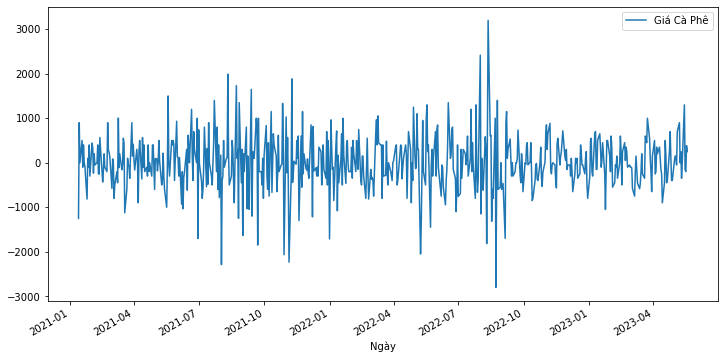

In [83]:
# Plot the time series
fig, ax = plt.subplots(figsize=(12, 6))
coffee_price_diff.plot(ax=ax)
plt.show()

In [84]:
#Finding non-seasonal orders, seasonal orders

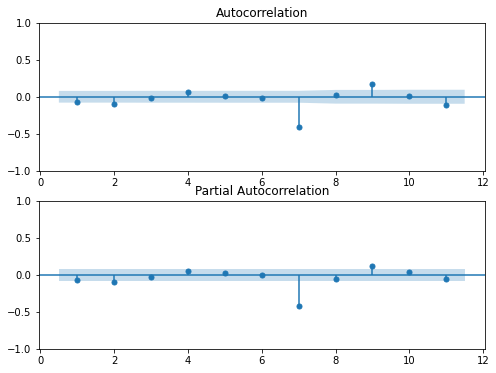

In [85]:
# Create the figure 
fig, (ax1, ax2) = plt.subplots(2,1,figsize=(8,6))

# Plot the ACF on ax1
plot_acf(coffee_price_diff, lags=11, zero=False, ax=ax1)

# Plot the PACF on ax2
plot_pacf(coffee_price_diff, lags=11, zero=False, ax=ax2)

plt.show()

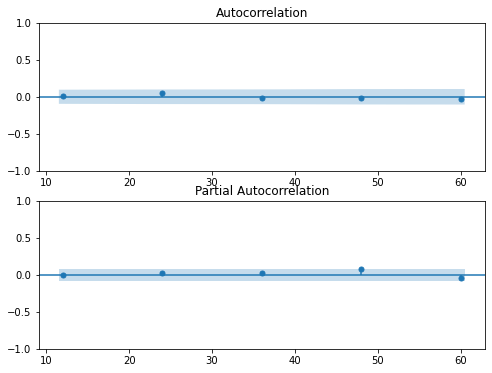

In [86]:
# Finding seasonal period using ACF (autocorrelation)
# We look for a lag greater than one, which is a peak in the ACF plot

# Make list of lags
lags = [12, 24, 36, 48, 60]

# Create the figure 
fig, (ax1, ax2) = plt.subplots(2,1,figsize=(8,6))

# Plot the ACF on ax1
plot_acf(coffee_price_diff, lags=lags, ax=ax1)

# Plot the PACF on ax2
plot_pacf(coffee_price_diff, lags=lags, ax=ax2)

plt.show()


In [90]:
# # Imports
# statsmodels.tsa.statespace.sarimax import SARIMAX
# # Instantiate model
# model = SARIMAX(coffee_df, order(p,d,q), seasonal_order=(P,D,Q,S))
# # Fit model
# results = model.fit()

# Import the SARIMAX class
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Create a SARIMA model
model = SARIMAX(coffee_df, order=(0,1,0), seasonal_order=(0,1,1,7))

# Fit the model
results = model.fit()

# Print the results summary
print(results.summary())

                                      SARIMAX Results                                      
Dep. Variable:                          Giá Cà Phê   No. Observations:                  624
Model:             SARIMAX(0, 1, 0)x(0, 1, [1], 7)   Log Likelihood               -4702.686
Date:                             Tue, 15 Aug 2023   AIC                           9409.371
Time:                                     14:22:37   BIC                           9418.218
Sample:                                          0   HQIC                          9412.811
                                             - 624                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.S.L7       -0.9566      0.019    -50.882      0.000      -0.993      -0.920
sigma2      1.968e+05   515

In [88]:
# Create ARIMA mean forecast
arima_pred = arima_results.get_forecast(steps=25)
arima_mean = arima_pred.predicted_mean

# Create SARIMA mean forecast
sarima_pred = sarima_results.get_forecast(steps=25)
sarima_mean = sarima_pred.predicted_mean

# Plot mean ARIMA and SARIMA predictions and observed
plt.plot(dates, sarima_mean, label='SARIMA')
plt.plot(dates, arima_mean, label='ARIMA')
plt.plot(wisconsin_test, label='observed')
plt.legend()
plt.show()

NameError: name 'arima_results' is not defined

In [27]:
#training and test set
training = coffee_df.iloc[:-31,:] #up to 31 day before the end of the data
test = coffee_df.iloc[-31:, :]

In [ ]:
# Fit data

In [28]:
test

,Giá Cà Phê
Ngày,
2023-04-07,49566.5
2023-04-10,49766.5
2023-04-11,50166.5
2023-04-12,50516.5
2023-04-13,50666.5
2023-04-14,50266.5
2023-04-17,50116.5
2023-04-18,50416.5
2023-04-19,50766.5


In [29]:
# Calculate the seasonal component by averaging values for each day of the week
# (assuming weekly seasonality)
training['Weekday'] = training.index.weekday
seasonal_composition = training.groupby('Weekday').mean()

# Impute missing values in the test set using the seasonal composition
for index, row in test.iterrows():
    if pd.isnull(row.iloc[0]):
        weekday = index.weekday()
        test.loc[index] = seasonal_composition.loc[weekday]

print(test)

            Giá Cà Phê
Ngày                  
2023-04-07     49566.5
2023-04-10     49766.5
2023-04-11     50166.5
2023-04-12     50516.5
2023-04-13     50666.5
2023-04-14     50266.5
2023-04-17     50116.5
2023-04-18     50416.5
2023-04-19     50766.5
2023-04-20     50716.5
2023-04-21     50666.5
2023-04-24     51066.5
2023-04-25     51366.5
2023-04-26     51316.5
2023-04-27     51216.5
2023-04-28     51166.5
2023-05-01     51166.5
2023-05-02     51266.5
2023-05-03     51816.5
2023-05-04     52066.5
2023-05-05     52716.5
2023-05-08     53516.5
2023-05-09     53466.5
2023-05-10     53716.5
2023-05-11     53466.5
2023-05-12     54016.5
2023-05-15     55566.5
2023-05-16     56066.5
2023-05-17     56666.5
2023-05-18     57000.0
2023-05-19     57500.0


# SARIMA Model for coffee data

In [30]:
# Check for stationarity using the Augmented Dickey-Fuller test
def check_stationarity(data):
    result = adfuller(data)
    p_value = result[1]
    if p_value <= 0.05:
        print("The data is stationary (p-value: {:.4f}).".format(p_value))
        return True
    else:
        print("The data is not stationary (p-value: {:.4f}). Differencing is needed.".format(p_value))
        return False

# Find the optimal SARIMA parameters using auto_arima
def find_optimal_params(data, seasonal=True):
    stepwise_fit = auto_arima(data, seasonal=seasonal, m=7, stepwise=True, suppress_warnings=True)
    return stepwise_fit.order, stepwise_fit.seasonal_order

# Fit SARIMA model and make predictions
def fit_sarima_model(train_data, order, seasonal_order):
    model = SARIMAX(train_data, order=order, seasonal_order=seasonal_order, enforce_stationarity=False,
                    enforce_invertibility=False)
    fitted_model = model.fit(disp=-1)
    return fitted_model

# Forecast coffee prices for the next 31 days
def forecast_sarima(model, steps):
    forecast = model.forecast(steps=steps)
    return forecast

In [31]:
# Check stationarity of the training data
is_stationary = check_stationarity(training)

# Find the optimal SARIMA parameters
if is_stationary:
    order, seasonal_order = find_optimal_params(training, seasonal=True)
else:
    order, seasonal_order = find_optimal_params(training, seasonal=False)

ValueError: x is required to have ndim 1 but has ndim 2

In [32]:
# Fit the SARIMA model
sarima_model = fit_sarima_model(training, order, seasonal_order)

NameError: name 'order' is not defined

In [33]:
# Forecast coffee prices for the next 31 days (Test set)
forecast_test = forecast_sarima(sarima_model, steps=31)

# Convert forecast_test to pandas Series with the correct index
forecast_test_series = pd.Series(forecast_test)
forecast_test_series.index = test.index

# Print the forecasted prices for the next 31 days (Test set)
print("Forecasted Coffee Prices for the Next 31 Days (Test Set):")
print(forecast_test_series)

NameError: name 'sarima_model' is not defined

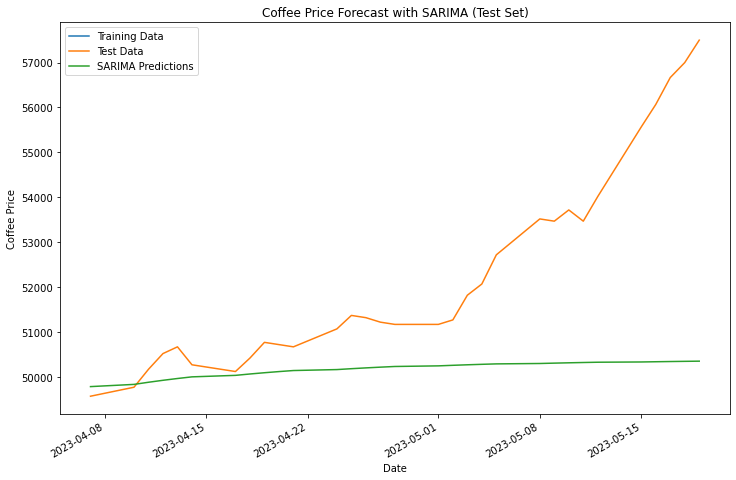

In [27]:
# Plot the training data, test data, and SARIMA predictions for the test set
plt.figure(figsize=(12, 8))
training['Giá']['2023-05-01':].plot(label='Training Data', legend=True)
test['Giá'].plot(label='Test Data', legend=True)
forecast_test.plot(label='SARIMA Predictions', legend=True)
plt.title('Coffee Price Forecast with SARIMA (Test Set)')
plt.xlabel('Date')
plt.ylabel('Coffee Price')
plt.legend()
plt.show()